# Session 13: Word Embeddings using the Word2Vec skip-gram model

------------------------------------------------------
*Machine Learning, Master in Big Data Analytics, 2017-2018*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------
The goal of this assignment is to train a Word2Vec skip-gram model over a data base of plain tex [Text8](http://mattmahoney.net/dc/textdata).

This is a personal wrap-up of all the material provided by [Google's Deep Learning course on Udacity](https://www.udacity.com/course/deep-learning--ud730), so all credit goes to them. 


The following [link](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) gives a very simple explanation of the model. Check also the following video.

**ALPER KOCABIYIK & GONZALO ALVAREZ**

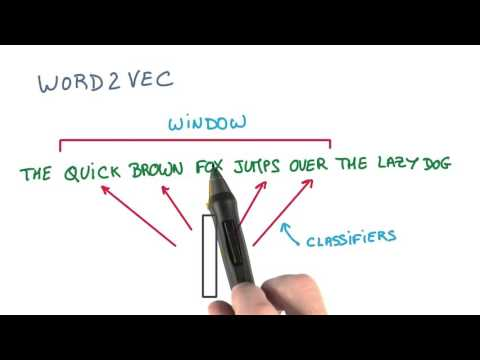

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('xMwx2A_o5r4')   

In [0]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE




In [3]:
# Lets check what version of tensorflow we have installed. The provided scripts should run with tf 1.0 and above

print(tf.__version__)

1.8.0


In [4]:
from google.colab import files
uploaded = files.upload()

We will use the plain text database from this [link](http://mattmahoney.net/dc/textdata.html)

In [5]:
filename = './text8.zip'
#Here I provide some text preprocessing functions
import preprocessing

ModuleNotFoundError: ignored

Read the data into a string

In [38]:
words = preprocessing.read_data(filename)
print('Data size %d' % len(words))

AttributeError: ignored

In [27]:
type(words)

NameError: ignored

In [1]:
print(words[0:20])

NameError: ignored

Build the dictionary and replace rare unfrequent words with UNK token. 

In [2]:
vocabulary_size = 50000

data, count, dictionary, reverse_dictionary = preprocessing.build_dataset(vocabulary_size,words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory use.

NameError: ignored

**Let**'s display the internal variables to better understand their structure:

In [3]:
print(data[:10])
print(count[:10])

NameError: ignored

In [4]:
print(list(dictionary.items())[:10])
print(list(reverse_dictionary.items())[:10])

NameError: ignored

In [5]:
print('The index of the word "crafty" in dictionary is %d\n' %(dictionary['crafty']))
print('The word corresponding to the index 875 is %s\n' %(reverse_dictionary[875]))

NameError: ignored

## Generating training batches

The function 'preprocessing.generate_batch' generates training batchs for the skip-gram model.


<img src="Fig1.png" width="600" height="400">

Figure borrowed from this [post](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).

In [6]:
data_index = 0

"""Generate a batch of data for training.
    Args:
        batch_size: Number of samples to generate in the batch.
        
        skip_window:# How many words to consider left and right.
        
            How many words to consider around the target word, left and right.
            With skip_window=2, in the sentence above for "consider" we'll
            build the window [words, to, consider, around, the].
            
        num_skips: How many times to reuse an input to generate a label.
        
            For skip-gram, we map target word to adjacent words in the window
            around it. This parameter says how many adjacent word mappings to
            add to the batch for each target word. Naturally it can't be more
            than skip_window * 2.
            
    Returns:
        batch, labels - ndarrays with IDs.
        batch: Row vector of size batch_size containing target words.
        labels:
            Column vector of size batch_size containing a randomly selected
            adjacent word for every target word in 'batch'.
    """


print('data:', [reverse_dictionary[di] for di in data[:32]])

for num_skips, skip_window in [(2, 4)]:
    data_index = 0
    batch, labels = preprocessing.generate_batch(data, data_index, batch_size=16, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(16)])

NameError: ignored

## Using the above data set, now we train a skip-gram model!

The following [link](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) gives a very simple explanation of the model. The following figures are borrowed from that post.

<img src="Fig2.png" width="600" height="400">

<img src="Fig3.png" width="600" height="400">

In [7]:
batch_size = 32
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 32 # Random set of words to evaluate similarity on.
valid_window = 200 # Only pick samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs. YOU DON'T NEED THE ONE HOT ENCODING FOR THE INPUT!!!! 
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, train_labels, 
                                                     embed, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

NameError: ignored

In [8]:
num_steps = 100001
data_index = 0

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):

        batch_data, batch_labels = preprocessing.generate_batch(data,data_index,batch_size, num_skips, skip_window) 
        data_index = (data_index + batch_size) % len(data)
        
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
            
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 25000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    
    final_embeddings = normalized_embeddings.eval()

NameError: ignored

This is what an embedding looks like:

In [0]:
print(final_embeddings[2,:])

[-0.01284116  0.06370314  0.00942189 -0.01602132  0.07380902  0.04375131
 -0.00536275 -0.03986432  0.06196572  0.04728323 -0.06939422  0.05216813
 -0.07189895 -0.08680649  0.175111    0.02106102 -0.00929935 -0.06048186
  0.03464364 -0.00890897  0.01135485 -0.07787979 -0.15920529 -0.10795777
 -0.01461228  0.04387816  0.09124263  0.07794994  0.01704169 -0.06789587
 -0.04556559  0.08053475  0.04520644  0.04617961  0.11115272  0.06227123
 -0.1828819   0.00407876 -0.01251844  0.13607536  0.10897586  0.13243057
 -0.10650989  0.02228085 -0.10272355 -0.05798529 -0.05263516 -0.24128814
 -0.02581607 -0.07971399  0.1369812   0.0072524   0.11279783  0.10323644
  0.07777879 -0.04932854 -0.05365378 -0.05353532 -0.05135224 -0.00755685
 -0.00152384 -0.07725015  0.06679566 -0.11252768 -0.01926792 -0.0611034
  0.05149738 -0.07176072  0.20261957 -0.06835694 -0.03730052  0.14804047
  0.24404204  0.03069032  0.06768436 -0.05709276 -0.02484669  0.0457652
  0.07585476  0.0883823  -0.01695413  0.04753481 -0.0

The embeddings have unit norm!

In [9]:
print(np.sum(np.square(final_embeddings[40000,:])))

NameError: ignored

Now we project the emmbeding vectors into a 2-dimensional space using [TSNE](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf)

We use the [TSNE sklearn implementation](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf)

In [0]:
num_points = 200

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=500)

two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

Lets visualize the result

In [10]:
def plot(embeddings, labels):
    print(labels)
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    print(embeddings.shape)
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

NameError: ignored

## Problem 4

1) Evaluate the efect of the number of negative samples used for the sampled soft max loss.

2) In the original [wor2vec paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) the authors showed an striking discovery: word analogy tasks can be solved by simple linear algebra. For example, the word analogy question **man-->woman-->king-->??** can be solved by looking for the embedding word $v_w$ such that $v_{\text{king}}-v_{w}$ is most similar to $v_{\text{man}}−v_{\text{woman}}$; in other words, minimizes 
\begin{align}
||v_{w}-v_{\text{king}}+v_{\text{man}}−v_{\text{woman}}||^2
\end{align}

Note that, in case the above norm is zero, this means that 
\begin{align}
v_{w} = v_{\text{king}}-v_{\text{man}}+v_{\text{woman}}
\end{align}

Try to study this effect in the set of word embeddings you just computed. Recall you can check the list of words in the list 'count'. **Note:** most likely it won't work, since we have used a very small database. But it will be fun to think about semantic operations in an embedding space though!

In [11]:
# 1.1)

def define_embed_graph(num_sampled):

  graph = tf.Graph()

  with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs. YOU DON'T NEED THE ONE HOT ENCODING FOR THE INPUT!!!! 
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, train_labels, 
                                                     embed, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
  
  
def run_graph(num_steps):
  
  data_index = 0

  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):

      batch_data, batch_labels = preprocessing.generate_batch(data,data_index,batch_size, num_skips, skip_window) 
      data_index = (data_index + batch_size) % len(data)
        
      feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
      _, l = session.run([optimizer, loss], feed_dict=feed_dict)
      average_loss += l
      if step % 2000 == 0:
        if step > 0:
          avg_loss = average_loss / 2000
          average_loss = 0
    final_embeddings = normalized_embeddings.eval()
    return avg_loss
  
  
num_negative_arr = [16, 32, 64, 128, 256, 512]
avg_loss = np.zeros(len(num_negative_arr))

for i in range(len(num_negative_arr)):
  batch_size = 32
  embedding_size = 128 
  skip_window = 1 
  num_skips = 2 
  valid_size = 32 
  valid_window = 200 
  valid_examples = np.array(random.sample(range(valid_window), valid_size))
  num_steps = 100001
  
  # define and run graph with 'num_negative_arr' number of negative samples
  define_embed_graph(num_negative_arr[i])
  avg_loss[i] = run_graph(num_steps)
  print ('Average loss with %d negative samples is %r' %(num_negative_arr[i], avg_loss[i]))


NameError: ignored

In [12]:
# 1.2)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(num_negative_arr, avg_loss)

NameError: ignored

In [13]:
words = [reverse_dictionary[i] for i in range(0, 50000)]

word1 = final_embeddings[[i for i in range(len(words)) if 'one'==words[i]][0],:] 
word2 = final_embeddings[[i for i in range(len(words)) if 'three'==words[i]][0],:]

word1_1 = final_embeddings[[i for i in range(len(words)) if 'english'==words[i]][0],:] 
word2_1 = final_embeddings[[i for i in range(len(words)) if 'country'==words[i]][0],:]
word3_1 = final_embeddings[[i for i in range(len(words)) if 'language'==words[i]][0],:]

word1_2 = final_embeddings[[i for i in range(len(words)) if 'absolutist'==words[i]][0],:] 
word2_2 = final_embeddings[[i for i in range(len(words)) if 'king'==words[i]][0],:]
word3_2 = final_embeddings[[i for i in range(len(words)) if 'government'==words[i]][0],:]

first_try = word1 + word2 #four in the third position
second_try = word1_1 + word2_1 - word3_1
third_try =  - word1_2 + word2_2 + word3_2#president in the third position


def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.linalg.norm(deltas, axis=1,ord=2)
    d_1 =np.argsort(dist_2)
    for i in range(15):
       print(reverse_dictionary[d_1[i]])
    return d_1

_ = closest_node(third_try,final_embeddings)

NameError: ignored